# AlphaFold Assessment of Interactions

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 5E-G
* Supplemental Figure 7A-E
* Supplemental Figure 8

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

For information on running AlphaFold, please see Example Analysis below and `Data/ExampleUsage/AlphaFold.README.md`

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neteval.network_statistics import NetworkStats, load_network_names
from neteval.alphafold_results import *
from tqdm import tqdm
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import warnings
import networkx as nx
import pickle
from collections import defaultdict
import random as rn
import glob

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
blue='#73c7e7'
green='#44cf6c'
orange='#ffa500'

In [3]:
gitdir = os.path.dirname(os.getcwd())
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
evaldir = os.path.join(gitdir, 'Data/example_outputs/')
datadir = os.path.join(gitdir, 'Data/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
example_names = load_network_names(os.path.join(gitdir, 'Data/example_network_names.txt'))
network_classes = load_network_names(os.path.join(gitdir, "StateOfTheInteractomes_Notebooks/Data/network_classifications.txt"))

In [4]:
# Load the AF results for randomly generated protein pairs
rn_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig5_Random_AF_results.csv'), index_col=0)

## Example Analysis

With DIP, PID2, and Wan

### Download Protein Sequence data from Uniprot

Uncomment to download the data (~15mins)

In [5]:
# from neteval.node_annotation import get_uniprot_annotation_data

# uni_df = get_uniprot_annotation_data(fields=['id', 'sequence', 'xref_geneid'], outdir=os.path.join(gitdir, 'Data/'), 
#                                     index_on=2, page_size=500, max_retries=5, taxid=9606, verbose=False)

### Selection of interactions to predict
1. Interactions with a range of network coverages
2. Random sample of interactions from each interactome
3. Top previously unreported interactions predicted by each interactome

In [6]:
# get the UniProt reference data - only possible to predict pairs with protein structures
uni_df = pd.read_csv(os.path.join(gitdir, 'Data/uniprot_data_id_sequence_xref_geneid_2024-02-05.tsv'), sep='\t', index_col=0)

In [7]:
with open(os.path.join(evaldir, "edge_counts.pkl"), 'rb') as f:
    edge_counts = pickle.load(f)
with open(os.path.join(evaldir, "node_mapping.pkl"), 'rb') as f:
    node_mapping = pickle.load(f)
    
rev_node_mapping = {v: k for k, v in node_mapping.items()}
mapped_edge_counts = {(rev_node_mapping[k[0]], rev_node_mapping[k[1]]): v for k, v in edge_counts.items()}
reverse_edge_counts = defaultdict(list)
for k in tqdm(edge_counts):
    edge = (rev_node_mapping[k[0]], rev_node_mapping[k[1]])
    if (edge[0] in uni_df.index) and( edge[1] in uni_df.index):
        reverse_edge_counts[edge_counts[k]].append(edge)

100%|██████████| 57646/57646 [00:00<00:00, 316749.68it/s]


In [8]:
rn_df['Entrez_A'] = rn_df['Pair_str'].apply(lambda x: sorted([int(y) for y in x.split('_')])[0])
rn_df['Entrez_B'] = rn_df['Pair_str'].apply(lambda x: sorted([int(y) for y in x.split('_')])[1])
rn_df['Edge_count'] = rn_df.apply(lambda x: mapped_edge_counts[(x.Entrez_A, x.Entrez_B)] if (x.Entrez_A, x.Entrez_B) in mapped_edge_counts else 0, axis=1)

1. Network Coverage Pairs

In [9]:
pairs_to_run = defaultdict(set)
rn_df = rn_df.dropna()
for i in range(0, 4):
    if i == 0:
        # get 50 interactions (from the random background) that are not present in any example interactomes
        rn_df['Entrez_A'] = rn_df['Pair_str'].apply(lambda x: sorted([int(y) for y in x.split('_')])[0])
        rn_df['Entrez_B'] = rn_df['Pair_str'].apply(lambda x: sorted([int(y) for y in x.split('_')])[1])
        rn_df['Edge_count'] = rn_df.apply(lambda x: mapped_edge_counts[(x.Entrez_A, x.Entrez_B)] if (x.Entrez_A, x.Entrez_B) in mapped_edge_counts else 0, axis=1)
        coverage_0_pairs = rn_df.loc[rn_df['Edge_count'] == i, ('Entrez_A', 'Entrez_B')]
        coverage_0_pairs = [tuple(x) for x in coverage_0_pairs.to_numpy()]
        while len(pairs_to_run[i]) < 50:
            test_pairs = rn.sample(coverage_0_pairs, 50-len(pairs_to_run[i]))
            for pair in test_pairs:
                # check that both proteins have a sequence
                if (pair[0] in uni_df.index.values) & (pair[1] in uni_df.index.values):
                    pairs_to_run[i].add(pair)
    else:
        # get 50 interactions with varying network coverage
        if len(reverse_edge_counts[i]) < 50:
            for pair in reverse_edge_counts[i]:
                if (pair[0] in uni_df.index.values) & (pair[1] in uni_df.index.values):
                    pairs_to_run[i].add(pair)
        else:
            while len(pairs_to_run[i]) < 50:
                test_pairs = rn.sample(reverse_edge_counts[i], 50-len(pairs_to_run[i]))
                for pair in test_pairs:
                    if (pair[0] in uni_df.index.values) & (pair[1] in uni_df.index.values):
                        pairs_to_run[i].add(pair)

In [10]:
for k in pairs_to_run:
    with open(os.path.join(evaldir, f'net_coverage_pairs_to_run_{k}.csv'), 'w') as f:
        for pair in pairs_to_run[k]:
            f.write(f'{pair[0]},{pair[1]}\n')

2. Network samples

In [11]:
stats = NetworkStats(os.path.join(datadir, 'example_prefix_file.txt'), evaldir)

In [12]:
net_edges_to_run = defaultdict(list)
for pref in stats.prefixes:
    edges = pd.read_csv(stats.edge_files[pref], sep='\t')
    edges = edges.loc[edges['Entrez_A'].isin(uni_df.index) & edges['Entrez_B'].isin(uni_df.index), ('Entrez_A', 'Entrez_B')].to_numpy()
    samp_idx = rn.sample(range(len(edges)), 50)
    samp_edges = edges[samp_idx]
    net_edges_to_run[pref] = samp_edges
    

In [13]:
for net in net_edges_to_run:
    with open(os.path.join(evaldir, f'net_pairs_to_run_{net}.csv'), 'w') as f:
        for pair in net_edges_to_run[net]:
            f.write(f'{pair[0]},{pair[1]}\n')

3. Previously unreported interactions

These are sourced directly from the `...unverified_top50_edges.txt` files generated during evaluation of network coverage (see `ExampleUsage/InteractionPrediction.README.md`. When this analysis is supplied with the sequence information from UniProt it selects from only interactions with both protein sequences available. 

### Extracting AF results

Example for processing the results for the pair BARD1 (ID:580) - BRCA1 (ID:672)

In [14]:
extract_scores((580, 672), os.path.join(gitdir, 'Data/example_outputs/AlphaFold/'))

{'ptm': [0.27, 0.28, 0.27, 0.28, 0.27], 'iptm': [0.48, 0.5, 0.49, 0.51, 0.5]}

## Load full results

In [15]:
af_df = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/TableS5.txt'), sep='\t')
# create pair strings
af_df['Pair_str'] = af_df['NCBI Gene ID A'].astype(int).astype(str) + '-' + af_df['NCBI Gene ID B'].astype(int).astype(str)


In [16]:
af_df[(af_df['Analysis Set']=='Unreported') & (af_df['Network/Network Coverage']=='BioGRID')].Pair_str.nunique()

49

## Figure 5E - Network Coverage vs AF ipTM

In [17]:
coverage_df = af_df.copy().loc[af_df['Analysis Set']=='Network Coverage', :]
coverage_df_top = coverage_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['Pair_str'], keep='first')

coverage_df_top['Network/Network Coverage'] = coverage_df_top['Network/Network Coverage'].astype(int)

In [18]:
coverage_df_top['Edge_Bin'] = coverage_df_top['Network/Network Coverage'].apply(lambda x: (x+3)//4)

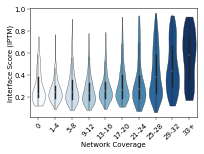

In [19]:
_ = plt.figure(figsize=(3, 2))
ax = plt.gca()
sns.violinplot(coverage_df_top, x='Edge_Bin', y='ipTM', ax=ax, cut=0, hue='Edge_Bin', palette='Blues', legend=False)
_ = plt.xticks([i for i in range(10)], labels=[0, '1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32', '33+'], rotation=45)
plt.ylabel('Interface Score (IPTM)')
plt.xlabel('Network Coverage')

plt.savefig(figdir + 'Fig5E_ipTM_vs_coverage.jpg', bbox_inches='tight', dpi=300)

## Figure 5F - ipTM of sample network interactions

In [20]:
# Load the AF results for random samples of 50 interactions per network.
network_df = af_df.copy().loc[af_df['Analysis Set']=='Network Specific', :]
network_df_top = network_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['Pair_str', 'Network/Network Coverage'], keep='first')


In [21]:
# Perform Mann Whitney U for ipTM scores. We consider both all random pairs, as well as 
# random pairs with no interactions reported in any of the 45 interactomes. We consider the
# full background of all random pairs as the primary metric. 
mu_results = {}
for net in network_df_top['Network/Network Coverage'].unique():
    mu_rn = mannwhitneyu(network_df_top[network_df_top['Network/Network Coverage'] == net].ipTM, rn_df[rn_df.Background=='All random'].iptm).pvalue
    mu_zero = mannwhitneyu(network_df_top[network_df_top['Network/Network Coverage'] == net].ipTM, rn_df[rn_df.Background=='No edges random'].iptm).pvalue
    mu_results[net] = {'rn': mu_rn, 'zero': mu_zero}
mu_df = pd.DataFrame.from_dict(mu_results, orient='index')
mu_df['fdr_rn'] = fdrcorrection(mu_df['rn'])[1]
mu_df['fdr_zero'] = fdrcorrection(mu_df['zero'])[1]

In [22]:
# Get the medians for each network, and background
random_median = rn_df[rn_df.Background=='All random'].iptm.median()
net_medians = network_df_top.groupby('Network/Network Coverage').ipTM.median()

In [23]:
# Subset the data to networks with significantly higher than expected ipTM scores
sig_nets = [x for x in list(mu_df[mu_df.fdr_rn < 0.15].index) if net_medians.loc[x] > random_median]
plot_data =network_df_top.copy()[network_df_top['Network/Network Coverage'].isin(sig_nets)]
plot_data['Class'] = plot_data['Network/Network Coverage'].map(network_classes)
order =plot_data.groupby('Network/Network Coverage').ipTM.median().sort_values(ascending=False).index

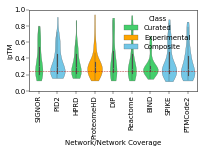

In [24]:
_ = plt.figure(figsize=(3,1.5))
sns.violinplot(data=plot_data, x='Network/Network Coverage', y='ipTM', cut=0, linewidth=0.25, hue='Class', palette=['#44cf6c', '#ffa500', '#73c7e7'], 
                saturation=1, order=order)#, cut=0, inner='', fill=True)
plt.hlines(rn_df.iptm.median(), -0.5, len(sig_nets) - 0.5, color='firebrick', linestyle='--', linewidth=0.5)
plt.ylim(0, 1)
plt.xlim(-0.5, len(sig_nets)-0.5)
ax  = plt.gca()
ax.tick_params(axis='x', rotation=90)
plt.savefig(figdir + 'Fig5F_Network_ipTM.jpg', bbox_inches='tight', dpi=300)

## Figure 5G - ipTM of potentially novel predicted interactions

In [25]:
unreported_df = af_df.copy()[af_df['Analysis Set'] == 'Unreported']
unreported_df_top = unreported_df.sort_values('Model Confidence', ascending=False).drop_duplicates(subset=['Pair_str', 'Network/Network Coverage'], keep='first')


In [26]:
# Identify threshold for AF-supported
iptm_th = rn_df[rn_df.Background=='No edges random'].sort_values('model_conf', ascending=False).drop_duplicates(subset=['Pair_str'], keep='first').iptm.describe(percentiles=[0.95])['95%']
print('ipTM threshold:', iptm_th)  

ipTM threshold: 0.56


In [27]:
unreported_df_top = unreported_df_top.assign(AFSupported = unreported_df_top.ipTM >= iptm_th)

In [28]:
print('Network validation rates:')
unreported_df_top.groupby('Network/Network Coverage').AFSupported.mean().sort_values(ascending=False).head(10)

Network validation rates:


Network/Network Coverage
SIGNOR        0.640000
Reactome      0.239130
MINT          0.120000
IntAct        0.102041
PID2          0.102041
iRefIndex     0.100000
DIP           0.093023
MatrixDB      0.081633
ProteomeHD    0.073171
SPIKE         0.068182
Name: AFSupported, dtype: float64

In [29]:
# Plot the 10 networks with the highest number of AF supported interactions
plot_nets = unreported_df_top.groupby('Network/Network Coverage').AFSupported.sum().sort_values(ascending=False).index[0:10]

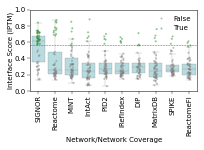

In [30]:
_ = plt.figure(figsize=(3,1.5))

sns.stripplot(data=unreported_df_top, x='Network/Network Coverage', y='ipTM', s=2, alpha=0.5, hue='AFSupported', palette=['forestgreen', 'grey'][::-1], order=plot_nets)
sns.boxplot(data=unreported_df_top[unreported_df_top['Network/Network Coverage'].isin(plot_nets)], x='Network/Network Coverage', y='ipTM', fliersize=0, linecolor='grey', color='powderblue', linewidth=0.25)
plt.hlines(iptm_th, -0.5, 9.5, color='forestgreen', linestyle='--', linewidth=0.5)
plt.ylim(0,1)
plt.ylabel('Interface Score (IPTM)')
plt.xlim(-0.5, 9.5)
plt.gca().tick_params(axis='x', rotation=90)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore deprecation warning
    plt.savefig(figdir + 'Fig5G_iptm_af_support.jpg', bbox_inches='tight', dpi=300)

Statistics

In [31]:
rn_df_top = rn_df.sort_values('model_conf', ascending=False).drop_duplicates(subset=['Pair_str'], keep='first')

In [32]:
# need to do a mann whitney u test for each network against the random pairs
muAF_results = {}
for net in unreported_df_top['Network/Network Coverage'].unique():
    muAF_rn = mannwhitneyu(unreported_df_top[unreported_df_top['Network/Network Coverage'] == net].ipTM, rn_df_top[rn_df_top.Background=='All random'].iptm).pvalue
    muAF_results[net] = {'p': muAF_rn, 'median': unreported_df_top[unreported_df_top['Network/Network Coverage'] == net].ipTM.median()}
muAF_df = pd.DataFrame.from_dict(muAF_results, orient='index')
muAF_df['q'] = fdrcorrection(muAF_df['p'])[1]
muAF_df['higher_ipTM'] = muAF_df['median'] > rn_df_top[rn_df_top.Background=='All random'].iptm.median()

In [33]:
muAF_df[muAF_df.higher_ipTM].sort_values('q')

,p,median,q,higher_ipTM
SIGNOR,6.397314e-18,0.610,2.367006e-16,True
PathwayCommons,5.521554e-03,0.280,2.029663e-02,True
SPIKE,1.246582e-02,0.260,3.547964e-02,True
Reactome,1.659992e-02,0.255,4.094648e-02,True
DIP,2.498499e-02,0.290,5.777779e-02,True
HPRD,4.045658e-02,0.265,8.316075e-02,True
MINT,5.583600e-02,0.260,9.837771e-02,True
PID2,5.511151e-02,0.270,9.837771e-02,True
iRefIndex,5.343209e-02,0.245,9.837771e-02,True
PhosphoSitePlus,7.653887e-02,0.260,1.287245e-01,True


## Supplemental Figures

### Load PDB data

For processing of raw PDB data, see `StateOFTheInteractomes_Notebooks/Supplemental_Code/PDB_processing.py`. For large datasets, PDB provides a batch download. Note that the data for complexes and single proteins were downloaded separately as outlined in the Methods:

> Lists of experimentally resolved structures in the Protein Data Bank (PDB) were downloaded on August 14, 2024. Interactions with experimentally resolved structures were broadly defined as any protein pair reported as part of a human complex with at least two distinct protein entities that could be mapped to NCBI Gene IDs via UniProt Accession Codes. Proteins with individual experimentally resolved structures were broadly defined as any protein identified from structures containing one distinct protein entity (including homodimers and partial structures) that could be mapped to NCBI Gene IDs via UniProt Accession Codes. 

**Usage:**
```
python PDB_processing.py <datadir> <download_id> <complex|protein>
# e.g. for complex data:
python PDB_processing.py /path/to/pdb c45a276a8adf932dc105b8942846e27b complex
```


In [34]:
pdb_edges = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS7_pdb_edge_list.txt'), sep='\t', index_col=0)
with open(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS7_pdb_node_list.txt'), 'r') as f:
    pdb_nodes = [int(x.strip()) for x in f.readlines()]

In [35]:
pdb_edges['Pair_str'] = pdb_edges['GeneA'].astype(str) + '-' + pdb_edges['GeneB'].astype(str)
pdb_edges['EdgeInPDB'] = 1

In [36]:
def add_pdb_info(top_mods_df, pdb_edge_list, singles, group_by, return_original_df=False):
    top_mods_df = top_mods_df.merge(pdb_edge_list.loc[:,('Pair_str', 'EdgeInPDB')], on='Pair_str', how='left')
    top_mods_df['NodesInPDB'] = top_mods_df.apply(lambda x: np.sum([int(x['NCBI Gene ID A']) in singles, int(x['NCBI Gene ID B']) in singles]) , axis=1)
    if return_original_df:
        return top_mods_df
    edge_df = top_mods_df.groupby(group_by).agg({
        'EdgeInPDB': 'value_counts'
    }).unstack().fillna(0)
    edge_df.columns = ['_'.join(map(str, col)).strip() for col in edge_df.columns.values]
    edge_df = edge_df.reset_index()
    aggregated_df = top_mods_df[top_mods_df['EdgeInPDB'].isna()].groupby(group_by).agg({
        'NodesInPDB': 'value_counts'
    }).unstack().fillna(0)
    aggregated_df.columns = ['_'.join(map(str, col)).strip() for col in aggregated_df.columns.values]

    # Reset the index for plotting
    aggregated_df = aggregated_df.reset_index()
    plot_pdb_df = aggregated_df.merge(edge_df, on=group_by, how='outer').set_index(group_by).fillna(0)
    bin_counts = top_mods_df[group_by].value_counts().sort_index()
    plot_pdb_df_frac = np.divide(plot_pdb_df.T,  bin_counts.values).T
    col_names = {'NodesInPDB_0': 'None', 'NodesInPDB_1': 'One Individual Protein', 'NodesInPDB_2': 'Both Individual Proteins', 'EdgeInPDB_1.0': 'Interaction'}
    return plot_pdb_df.rename(columns=col_names), plot_pdb_df_frac.rename(columns=col_names)

### Figure S7A - PDB vs Network Coverage

In [37]:
coverage_pdb, coverage_pdb_frac = add_pdb_info(coverage_df_top, pdb_edges, pdb_nodes, group_by='Edge_Bin')

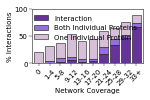

In [38]:
_ = plt.figure(figsize=(2, 1))
ax = plt.gca()
plot_pdb_df_frac = coverage_pdb_frac.loc[:, ('Interaction', 'Both Individual Proteins', 'One Individual Protein')]
plot_pdb_df_frac.plot(kind='bar', stacked=True, color=['rebeccapurple', 'mediumpurple', 'thistle'], ax=ax, 
                      width=0.8, edgecolor='black', linewidth=0.5)

_ = plt.xticks([i for i in range(10)], labels=[0, '1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32', '33+'], 
               rotation=45)
plt.ylabel('% Interactions')
plt.xlabel('Network Coverage')
_ = plt.yticks([0,0.5,1], ['0', '50', '100'])

plt.savefig(os.path.join(figdir, 'FigS7A_PDB_coverage_bar_plot.jpg'), bbox_inches='tight')


### Figure S7B - PDB representation of network sampled interactions

In [39]:
network_pdb, network_pdb_frac = add_pdb_info(network_df_top, pdb_edges, pdb_nodes,group_by='Network/Network Coverage' )

In [40]:
net_order = network_df_top.groupby('Network/Network Coverage').ipTM.median().sort_values(ascending=False).index.to_list()

In [41]:
# consider networks with significantly different median ipTM in either direction
sig_nets = [x for x in list(mu_df[mu_df.fdr_rn < 0.15].index)]

In [42]:
network_df_top['Class'] = network_df_top['Network/Network Coverage'].apply(lambda x: network_classes[x] if x in sig_nets else 'x')

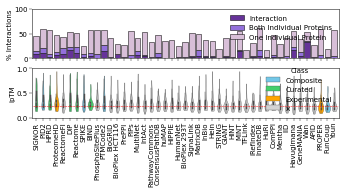

In [43]:
_, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(5.5, 2), sharex=True)
sns.violinplot(network_df_top, x='Network/Network Coverage', y='ipTM', hue='Class',
               palette = [blue, green, orange, 'lightgrey'], hue_order=['Composite', 'Curated', 'Experimental', 'x'], 
               order=net_order, ax=ax2, saturation=1, cut=0)
ax2.hlines(random_median, -0.5, 44.5,color='red', linestyle='--', linewidth=0.5)
ax2.tick_params(axis='x', rotation=90)
ax2.set_xlim(-0.5, 44.5)


net_pdb_df_frac = network_pdb_frac.loc[:,  ('Interaction', 'Both Individual Proteins', 'One Individual Protein')]
net_pdb_df_frac.loc[net_order].plot(kind='bar', stacked=True, color=['rebeccapurple', 'mediumpurple', 'thistle'], ax=ax1, 
                                    width=0.8, edgecolor='black', linewidth=0.5)
ax1.set_ylabel('% Interactions')
_ = ax1.set_yticks([0,0.5,1], ['0', '50', '100'])
ax2.set_ylim(0,1)
plt.savefig(os.path.join(figdir, 'FigS7B_pdb_network_specific_full_results.jpg'),dpi=400, bbox_inches='tight')
_ = ax2.set_xlabel('')

### Figure S7C - Correlation between PDB presence and ipTM score

In [44]:
plot_scatter = network_pdb_frac.join(network_df_top.groupby('Network/Network Coverage').ipTM.mean())

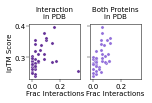

In [45]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(2,1), sharex=True, sharey=True)
sns.scatterplot(plot_scatter, x='Both Individual Proteins', y='ipTM', color='mediumpurple', ax=ax2, s=10)
sns.scatterplot(plot_scatter, x='Interaction', y='ipTM', color='rebeccapurple', ax=ax1, s=10)
ax1.set_ylabel('ipTM Score')
ax1.set_xlabel('Frac Interactions')
_ = ax1.set_title('Interaction\nin PDB', fontsize=7)
_ = ax2.set_title('Both Proteins\nin PDB', fontsize=7)
ax2.set_xlabel('Frac Interactions')
plt.savefig(os.path.join(figdir, 'FigS7C_pdb_network_scatter.jpg'), dpi=400, bbox_inches='tight')

In [46]:
plot_scatter.corr().ipTM

None                       -0.288846
One Individual Protein     -0.008404
Both Individual Proteins    0.526600
Interaction                 0.286301
ipTM                        1.000000
Name: ipTM, dtype: float64

### Figure S7D - AF Support for previously unreported interactions across all networks

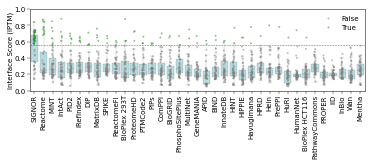

In [47]:
_ = plt.figure(figsize=(6,1.5))
plot_all_nets = unreported_df_top.groupby('Network/Network Coverage').AFSupported.sum().sort_values(ascending=False).index

sns.stripplot(data=unreported_df_top, x='Network/Network Coverage', y='ipTM', s=2, alpha=0.5, hue='AFSupported', palette=['forestgreen', 'grey'][::-1], order=plot_all_nets)
sns.boxplot(data=unreported_df_top[unreported_df_top['Network/Network Coverage'].isin(plot_all_nets)], x='Network/Network Coverage', y='ipTM', fliersize=0, linecolor='grey', color='powderblue', linewidth=0.25)
plt.hlines(iptm_th, -0.5, len(plot_all_nets)-0.5, color='forestgreen', linestyle='--', linewidth=0.5)
plt.ylim(0,1)
plt.ylabel('Interface Score (IPTM)')
plt.xlim(-0.5, len(plot_all_nets)-0.5)
_ = plt.xlabel('')
plt.gca().tick_params(axis='x', rotation=90)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore deprecation warning
    plt.savefig(figdir + 'FigS7D_iptm_af_support.jpg', bbox_inches='tight', dpi=300)

### Figure S7E - PDB presence of AF-supported, previously unreported interactions

In [48]:
supported_pdb_df, supported_pdb_df_frac = add_pdb_info(unreported_df_top[unreported_df_top.AFSupported], 
                                                   pdb_edges, pdb_nodes, 'Network/Network Coverage')

In [49]:
unsupported_pdb_df, unsupported_pdb_df_frac = add_pdb_info(unreported_df_top[~unreported_df_top.AFSupported], 
                                                 pdb_edges, pdb_nodes, 'Network/Network Coverage')

In [50]:
# add null data for networks with no AF-supported interactions
missing_nets = [net for net in order if net not in supported_pdb_df_frac.index]
add_df = pd.DataFrame({x:0 for x in supported_pdb_df_frac.columns}, index=missing_nets)
supported_pdb_df_frac = pd.concat([supported_pdb_df_frac, add_df])

In [51]:
supported = supported_pdb_df.sum(axis=0)
unsupported = unsupported_pdb_df.sum(axis=0)
results_mat = pd.DataFrame({'Supported':supported, "Unsupported":unsupported})

Perform chi-squared test

In [52]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(results_mat)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 3.917780398475503
P-value: 0.14101483248073257
Degrees of freedom: 2
Expected frequencies:
[[  88.16779279 1238.83220721]
 [  27.77252252  390.22747748]
 [   2.05968468   28.94031532]]


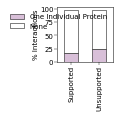

In [53]:
_ = plt.figure(figsize=(1,1))
ax = plt.gca()
# 'rebeccapurple', 'mediumpurple', 'thistle', 'white'
prop_df = np.divide(results_mat, results_mat.sum(axis=0))
prop_df.T.loc[:, ( 'One Individual Protein', 'None')].plot(kind='bar', stacked=True, color=['thistle', 'white'], edgecolor='black', linewidth=0.5, ax=ax)
plt.ylabel('% Interactions')
_ = plt.yticks([0, 0.25, 0.5, 0.75, 1], [0, 25, 50, 75, 100])
plt.savefig(os.path.join(figdir, 'FigS7E_iptm_supported_pdb_bars.jpg'), bbox_inches='tight')

### Supplemental Figure 8 - AF Supported Interactions

In [54]:
unreported_df_top[unreported_df_top.AFSupported].head()

,NCBI Gene ID A,NCBI Gene ID B,Network/Network Coverage,Analysis Set,Model Number,pTM,ipTM,Model Confidence,Pair_str,AFSupported
6357,2775,25816,SIGNOR,Unreported,2,0.86,0.84,0.844,2775-25816,True
1047,389,85415,Reactome,Unreported,2,0.74,0.87,0.844,389-85415,True
8086,3265,342897,MINT,Unreported,4,0.79,0.85,0.838,3265-342897,True
1077,11031,160518,Reactome,Unreported,2,0.73,0.85,0.826,11031-160518,True
1167,10890,160518,Reactome,Unreported,2,0.73,0.84,0.818,10890-160518,True


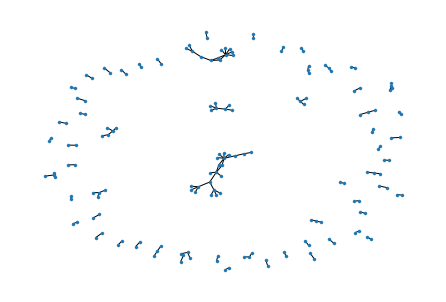

In [55]:
G_supported = nx.from_pandas_edgelist(unreported_df_top[unreported_df_top.AFSupported], source='NCBI Gene ID A', 
                                      target='NCBI Gene ID B', 
                                      edge_attr=['Network/Network Coverage', 'pTM', 'ipTM', 'Model Confidence'])
nx.draw_spring(G_supported, node_size=10)